In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord 
from astropy.nddata import Cutout2D
from astropy.time import Time
import astropy.units as u
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch
from matplotlib.widgets import Slider, TextBox
import lsdb
from dask.distributed import Client
print('imported libraries')

imported libraries


In [3]:
# Set target coordinates and cutout size
target_coord = SkyCoord(ra=202.951993 * u.deg, dec=-1.285494 * u.deg, frame='icrs')
cutout_size = 10 * u.arcsec
fits_dir = "../../../../shared/hsc_images_ra=202.95deg_dec=-1.28deg_radius=0.02deg/"

# Proper motion data (mas/yr)
ra = 202.951993
dec = -1.285494
pm_ra = -414.209178     # in mas/yr
pm_dec = -1041.278255   # in mas/yr
print('defined vars')

defined vars


In [4]:
def rotate_vector(v, theta, origin=(0, 0)):
    """
    Rotate point v by angle theta around origin.
    
    Parameters:
        v: array-like, shape (2,)
        theta: float, angle in radians
        origin: array-like, shape (2,), the center of rotation

    Returns:
        Rotated vector as a NumPy array
    """
    v = np.array(v)
    origin = np.array(origin)
    
    # Translate to origin
    translated = v - origin
    
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    
    # Rotate and translate back
    rotated = np.matmul(rotation_matrix, translated) + origin
    return rotated


Running loop
202.951993 -1.285494 -414.209178 -1041.278255
three_years: <SkyCoord (ICRS): (ra, dec) in deg
    (202.95164765, -1.28636173)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-414.31359265, -1041.27819868, 0.04888835)>


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/tmp/ipykernel_101471/3642505215.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


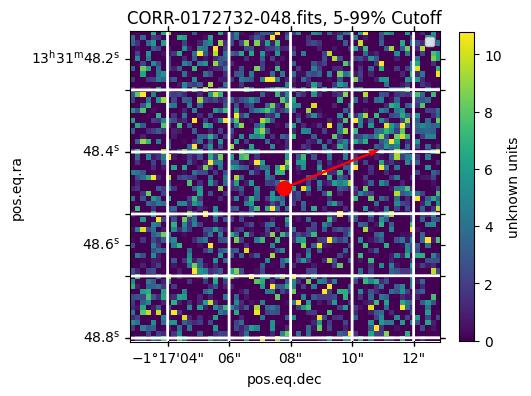

202.951993 -1.285494 -414.209178 -1041.278255
-414.209178 -1041.278255
-414.209178 -1041.278255
three_years: <SkyCoord (ICRS): (ra, dec) in deg
    (202.95164765, -1.28636173)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-414.31359265, -1041.27819868, 0.04888835)>


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/tmp/ipykernel_101471/3642505215.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


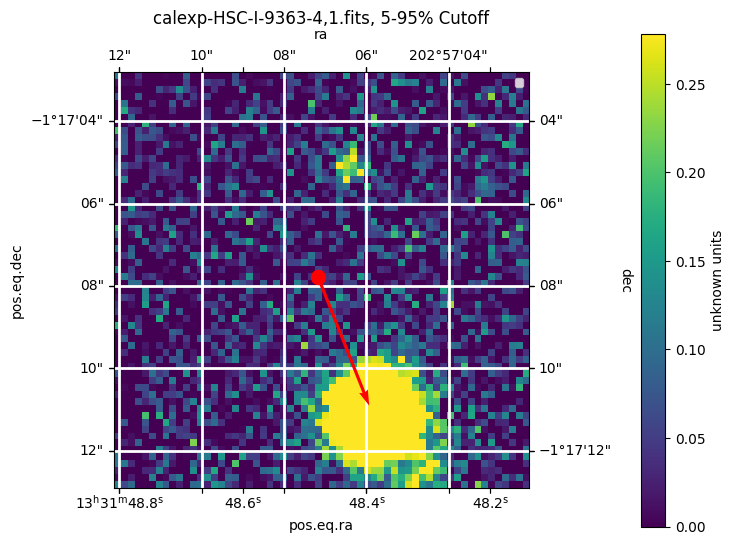

202.951993 -1.285494 -414.209178 -1041.278255
three_years: <SkyCoord (ICRS): (ra, dec) in deg
    (202.95164765, -1.28636173)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-414.31359265, -1041.27819868, 0.04888835)>


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/tmp/ipykernel_101471/3642505215.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


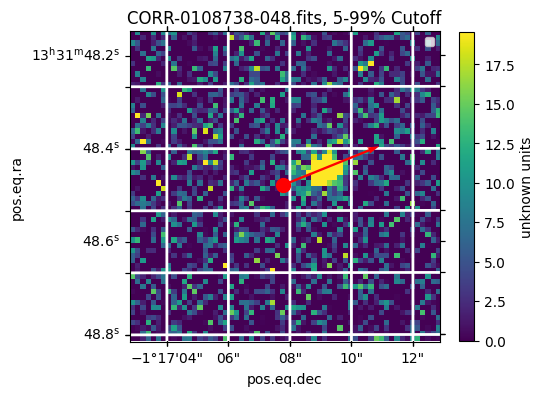

completed loop


In [34]:
print('Running loop')
# Loop through all FITS files
for fname in os.listdir(fits_dir):
    if ((not fname == 'CORR-0172732-048.fits') and
     (not fname == 'calexp-HSC-I-9363-4,1.fits') and 
     (not fname == 'CORR-0108738-048.fits')):
        continue
    fpath = os.path.join(fits_dir, fname)
    try:
        with fits.open(fpath) as hdul:
            for hdu in hdul:
                if hdu.data is not None:
                    try:
                        wcs = WCS(hdu.header)
                        cutout = Cutout2D(hdu.data, target_coord, cutout_size, wcs=wcs)
                        print(ra, dec, pm_ra, pm_dec)

                        im_ra, im_dec, im_pm_ra, im_pm_dec = ra, dec, pm_ra, pm_dec
                        pad = 0.05
                        figsize = (5, 5)
                        title_pad=6
                        lower_cutoff = 5
                        upper_cutoff = 99

                        if 'calexp' in fpath: 
                            print(im_pm_ra, im_pm_dec)
                            # im_pm_ra, im_pm_dec = rotate_vector((im_pm_ra, im_pm_dec), 90, origin=(im_ra, im_dec))
                            print(im_pm_ra, im_pm_dec)
                            # cutout.data = np.rot90(cutout.data, k=3)
                            pad = 0.18
                            figsize = (8,8)
                            title_pad = 35
                            upper_cutoff = 95
                            
                        ra_cos_dec = im_pm_ra / np.cos(np.radians(im_dec))
                        pm_star = SkyCoord(ra=ra * u.deg, 
                                           dec=dec * u.deg, 
                                           pm_ra_cosdec=ra_cos_dec*u.mas/u.yr, 
                                           pm_dec=pm_dec*u.mas/u.yr,
                                           obstime=Time('J2016')
                        )   
                        
                        # Convert to pixel position on the cutout WCS
                        origin = skycoord_to_pixel(pm_star, cutout.wcs)
                    
                        three_years = pm_star.apply_space_motion(new_obstime=Time('J2019'))
                        print(f'three_years: {three_years}')
                        end_vec = skycoord_to_pixel(three_years, cutout.wcs)
                        
                        # Make the plot
                        fig = plt.figure(figsize=figsize)
                        ax = fig.add_subplot(111, projection=cutout.wcs)
                        vmin, vmax = np.percentile(cutout.data, [lower_cutoff, upper_cutoff])
                        im = ax.imshow(cutout.data, origin='lower', cmap='viridis', vmin=0, vmax=vmax)
                        ax.set_title(f'{fname}, {lower_cutoff}-{upper_cutoff}% Cutoff', pad=title_pad)

                        # Overlay
                        overlay = ax.get_coords_overlay('icrs')
                        overlay.grid(color='white', linestyle='solid', alpha=1, linewidth=2, zorder=1)

                        # Colorbar
                        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=pad, shrink=0.8)
                        unit = hdu.header.get('BUNIT', 'unknown units')
                        cbar.set_label(unit)

                        # Plot Vector
                        vec = np.array(end_vec) - np.array(origin)
                        ax.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
                        ax.plot(*origin, marker='o', color='red', markersize=10, zorder=10)
                        ax.legend(loc='upper right', fontsize=8)
                        
                        plt.show()
                        break
                    except Exception as e:
                        if str(e) != 'Arrays do not overlap.' and str(e) != 'WCS should contain celestial component':
                            print(f"[Inner Error] {fname}: {e}")
                        continue
    except Exception as e:
        print(f"[Outer Error] Skipped {fname}: {e}")
print('completed loop')

In [15]:
%%time
with Client():
    hsc_p3_r = (
        lsdb.read_hats('../../../../shared/hats/catalogs/hsc_pdr3/hsc_pdr3-forced-R', 
        margin_cache='../../../../shared/hats/catalogs/hsc_pdr3/hsc_pdr3-forced-R_10arcs')
        .cone_search(ra=ra, dec=dec, radius_arcsec=8).compute()
    )
hsc_p3_r

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39211 instead
  warnings.warn(
2025-06-05 14:16:54,662 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


CPU times: user 3.66 s, sys: 1.46 s, total: 5.13 s
Wall time: 4min 32s


,id,coord_ra,coord_dec,parent,deblend_nChild,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_TransformedCentroid_x,base_TransformedCentroid_y,base_InputCount_value,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_TransformedShape_xx,base_TransformedShape_yy,base_TransformedShape_xy,modelfit_DoubleShapeletPsfApprox_0_xx,modelfit_DoubleShapeletPsfApprox_0_yy,modelfit_DoubleShapeletPsfApprox_0_xy,modelfit_DoubleShapeletPsfApprox_0_x,modelfit_DoubleShapeletPsfApprox_0_y,modelfit_DoubleShapeletPsfApprox_0_0,modelfit_DoubleShapeletPsfApprox_0_1,modelfit_DoubleShapeletPsfApprox_0_2,modelfit_DoubleShapeletPsfApprox_0_3,modelfit_DoubleShapeletPsfApprox_0_4,modelfit_DoubleShapeletPsfApprox_0_5,modelfit_DoubleShapeletPsfApprox_1_xx,modelfit_DoubleShapeletPsfApprox_1_yy,modelfit_DoubleShapeletPsfApprox_1_xy,modelfit_DoubleShapeletPsfApprox_1_x,modelfit_DoubleShapeletPsfApprox_1_y,modelfit_DoubleShapeletPsfApprox_1_0,modelfit_DoubleShapeletPsfApprox_1_1,modelfit_DoubleShapeletPsfApprox_1_2,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr,base_CircularApertureFlux_17_0_instFlux,base_CircularApertureFlux_17_0_instFluxErr,base_CircularApertureFlux_25_0_instFlux,base_CircularApertureFlux_25_0_instFluxErr,base_CircularApertureFlux_35_0_instFlux,base_CircularApertureFlux_35_0_instFluxErr,base_CircularApertureFlux_50_0_instFlux,base_CircularApertureFlux_50_0_instFluxErr,base_CircularApertureFlux_70_0_instFlux,base_CircularApertureFlux_70_0_instFluxErr,base_GaussianFlux_instFlux,base_GaussianFlux_instFluxErr,base_LocalBackground_instFlux,base_LocalBackground_instFluxErr,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_area,base_Variance_value,ext_photometryKron_KronFlux_instFlux,ext_photometryKron_KronFlux_instFluxErr,ext_photometryKron_KronFlux_radius,ext_photometryKron_KronFlux_radius_for_radius,ext_photometryKron_KronFlux_psf_radius,ext_convolved_ConvolvedFlux_seeing,ext_convolved_ConvolvedFlux_0_3_3_instFlux,ext_convolved_ConvolvedFlux_0_3_3_instFluxErr,ext_convolved_ConvolvedFlux_0_4_5_instFlux,ext_convolved_ConvolvedFlux_0_4_5_instFluxErr,ext_convolved_ConvolvedFlux_0_6_0_instFlux,ext_convolved_ConvolvedFlux_0_6_0_instFluxErr,ext_convolved_ConvolvedFlux_0_kron_instFlux,ext_convolved_ConvolvedFlux_0_kron_instFluxErr,ext_convolved_ConvolvedFlux_1_3_3_instFlux,ext_convolved_ConvolvedFlux_1_3_3_instFluxErr,ext_convolved_ConvolvedFlux_1_4_5_instFlux,ext_convolved_ConvolvedFlux_1_4_5_instFluxErr,ext_convolved_ConvolvedFlux_1_6_0_instFlux,ext_convolved_ConvolvedFlux_1_6_0_instFluxErr,ext_convolved_ConvolvedFlux_1_kron_instFlux,ext_convolved_ConvolvedFlux_1_kron_instFluxErr,ext_convolved_ConvolvedFlux_2_3_3_instFlux,ext_convolved_ConvolvedFlux_2_3_3_instFluxErr,ext_convolved_ConvolvedFlux_2_4_5_instFlux,ext_convolved_ConvolvedFlux_2_4_5_instFluxErr,ext_convolved_ConvolvedFlux_2_6_0_instFlux,ext_convolved_ConvolvedFlux_2_6_0_instFluxErr,ext_convolved_ConvolvedFlux_2_kron_instFlux,ext_convolved_ConvolvedFlux_2_kron_instFluxErr,ext_convolved_ConvolvedFlux_3_3_3_instFlux,ext_convolved_ConvolvedFlux_3_3_3_instFluxErr,ext_convolved_ConvolvedFlux_3_4_5_instFlux,ext_convolved_ConvolvedFlux_3_4_5_instFluxErr,ext_convolved_ConvolvedFlux_3_6_0_instFlux,ext_convolved_ConvolvedFlux_3_6_0_instFluxErr,ext_convolved_ConvolvedFlux_3_kron_instFlux,ext_

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


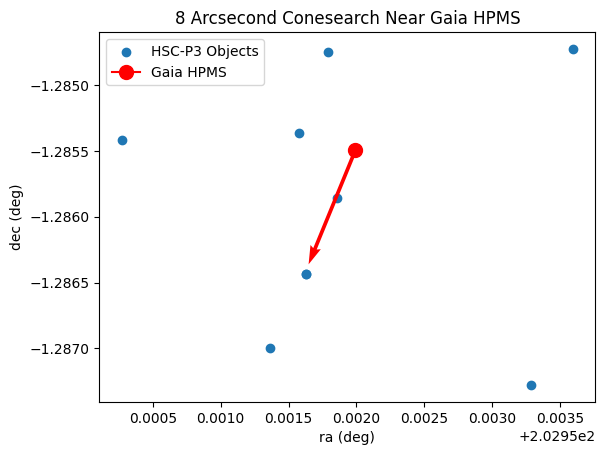

In [32]:
# Find Gaia Star and Motion:
years = 3
pm_ra_cosdec = pm_ra / np.cos(np.radians(dec))
coord = SkyCoord(ra=ra * u.deg,
                 dec=dec * u.deg,
                 pm_ra_cosdec=pm_ra_cosdec * u.mas/u.yr,
                 pm_dec=pm_dec * u.mas/u.yr,
                 obstime='J2020')      # reference epoch

new_coord = coord.apply_space_motion(dt=years * u.yr)

# Plot stars
plt.scatter(hsc_p3_r['coord_ra'], hsc_p3_r['coord_dec'], label='HSC-P3 Objects')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('8 Arcsecond Conesearch Near Gaia HPMS')

# Plot Gaia Star
origin = coord.ra.deg, coord.dec.deg
predicted_pos = new_coord.ra.deg, new_coord.dec.deg
vec = np.array(predicted_pos) - np.array(origin) 
plt.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
plt.plot(*origin, marker='o', color='red', markersize=10, zorder=10, label='Gaia HPMS')
plt.legend()

In [2]:
# std lib
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

# 3rd party
from numpy.core.defchararray import startswith
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib
%matplotlib inline

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Data Lab
from dl import queryClient as qc, storeClient as sc, authClient as ac
print('imported libraries')

/var/tmp/ipykernel_57669/2019475796.py:8: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.startswith.
  from numpy.core.defchararray import startswith


imported libraries


In [4]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

Enter user name: (+ENTER)  joaopassos
Enter password: (+ENTER)  ········


'joaopassos'

In [5]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2_se"
des_dr2 = sia.SIAService(DEF_ACCESS_URL)
ra = 42.817451981441494 # in degrees
dec = -3.8882601693023133 # in degrees
pm_ra = 1112.662482
pm_dec = -1853.859953
fov = 20/3600 # 20 arcseconds

In [29]:
imgTable = des_dr2.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00710668_g_c28_r3518p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556",image/fits,14532,,,3,0,0,2,[2048 4096],,,[-0.13168],,des_dr2_se,,DES DR2,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00710668_g_c28_r3518p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00710668_g_c28_r3518p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556&preview=true",,,42.712,-3.95354,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00700339_z_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556",image/fits,14501,,,3,0,0,2,[2048 4096],,,[-0.13174],,des_dr2_se,,DES DR2,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00700339_z_c28_r3517p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00700339_z_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556&preview=true",,,42.7124,-3.95293,--,,,--,-9.42906e-41,9.42906e-41,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556",image/fits,14456,,,3,0,0,2,[2048 4096],,,[-0.13173],,des_dr2_se,,DES DR2,archival,,,DECam,i DECam SDSS c0003 7835.0 1470.0,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00692095_i_c28_r3517p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556&preview=true",,,42.713,-3.95132,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DES DR2,0,IMAGE,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0055683728688726624,0.005555555555555556",image/fits,14456,,,3,0,0,2,[2048 4096],,,[-0.13173],,des_dr2_se,,DES DR2,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00692095_i_c28_r3517p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_

In [35]:
np.unique(imgTable['proctype'])

Stack


In [18]:
from datetime import datetime

def truncate(x):
    return int(x * 1000) / 1000

def plot_imgs_with_gaia_vec(imgTable, ra, dec, pm_ra, pm_dec, mag):
    sel = startswith(imgTable['obs_bandpass'].astype(str), 'g')
    selected = imgTable[sel]
    num_imgs = len(selected)
    print(num_imgs)
    if num_imgs < 4:
        assert False

    # Step 1: Extract dates and store with indices
    date_index_list = []
    for idx, row in enumerate(selected):
        try:
            url = row['access_url']
            filename = download_file(url, cache=True, show_progress=False, timeout=120)
            hdr = fits.open(filename)[0].header
            obs_date = hdr['DATE-OBS'].split('T')[0]
            date_obj = datetime.strptime(obs_date, "%Y-%m-%d")
            date_index_list.append((date_obj, idx, hdr))  # Save header to avoid reloading
        except Exception as e:
            print(f"Skipping image {idx} due to error extracting date: {e}")

    # Step 2: Sort by date
    date_index_list.sort()

    # Prepare figure
    cols = int(np.ceil(np.sqrt(num_imgs)))
    rows = int(np.ceil(num_imgs / cols))
    fig = plt.figure(figsize=(18, 16))
    fig.suptitle(f"DES High PM Star Images, g band\n RA:{truncate(ra)}, DEC:{truncate(dec)}, Gaia-Mag:{truncate(mag)}", 
                 fontsize=28, y=0.96)

    for plot_idx, (date_obj, original_idx, hdr) in enumerate(date_index_list):
        try:
            # Reload row and image
            row = selected[original_idx]
            url = row['access_url']
            filename = download_file(url, cache=True, show_progress=False, timeout=120)
            hdu = fits.open(filename)[0]
            image = hdu.data
            wcs = WCS(hdr)
            print(
            obs_date_str = date_obj.strftime("%Y-%m-%d")

            # Create subplot
            ax = fig.add_subplot(rows, cols, plot_idx + 1, projection=wcs)
            im = ax.imshow(image, origin='lower', vmin=0, vmax=100)
            ax.set_xlabel('DEC')
            ax.set_ylabel('RA', labelpad=-1)
            ax.set_title(f'Date: {obs_date_str}', fontsize=16)
            fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8)

            # Gaia Vector
            pm_ra_cosdec = pm_ra / np.cos(np.radians(dec))
            coord = SkyCoord(ra=ra * u.deg,
                             dec=dec * u.deg,
                             pm_ra_cosdec=pm_ra_cosdec * u.mas/u.yr,
                             pm_dec=pm_dec * u.mas/u.yr, obstime='J2013')
            new_coord = coord.apply_space_motion(new_obstime=Time('J2017'))

            end_vec = skycoord_to_pixel(new_coord, wcs)
            origin = skycoord_to_pixel(coord, wcs)
            vec = np.array(end_vec) - np.array(origin)
            ax.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
            ax.plot(*origin, marker='o', color='red', markersize=10, zorder=10)

        except Exception as e:
            print(f'Failed to plot image {plot_idx}, error: {e}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_catalog_images(URL, ra, dec, pm_ra, pm_dec, mag):
    catalog = sia.SIAService(URL)
    fov = 20/3600 # 20 arcseconds
    imgTable = catalog.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    plot_imgs_with_gaia_vec(imgTable, ra, dec, pm_ra, pm_dec, mag)
    return None    

9


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

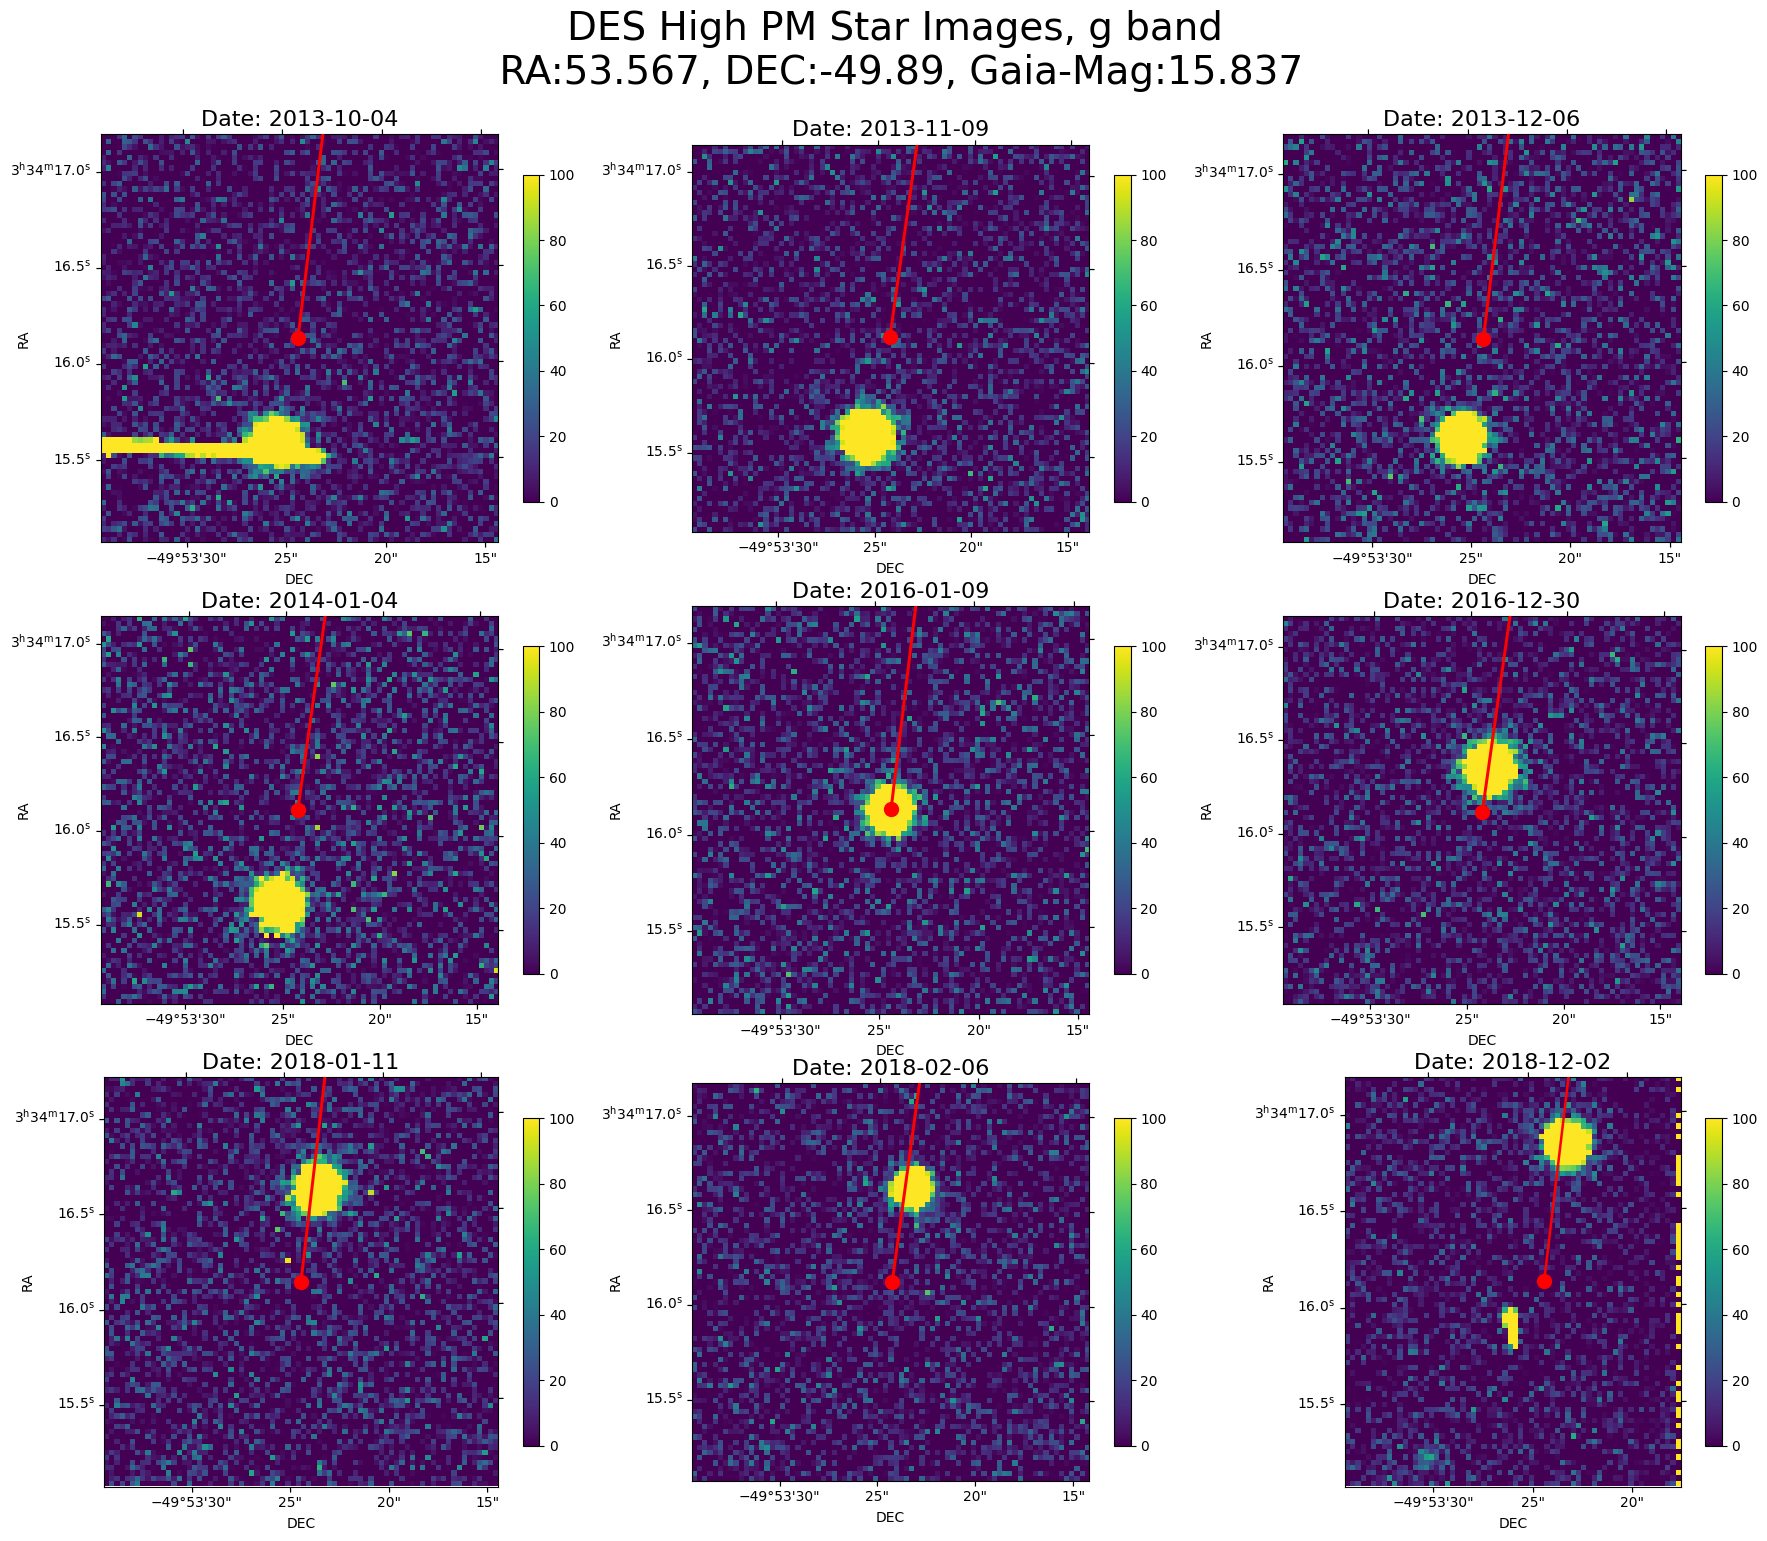

8


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

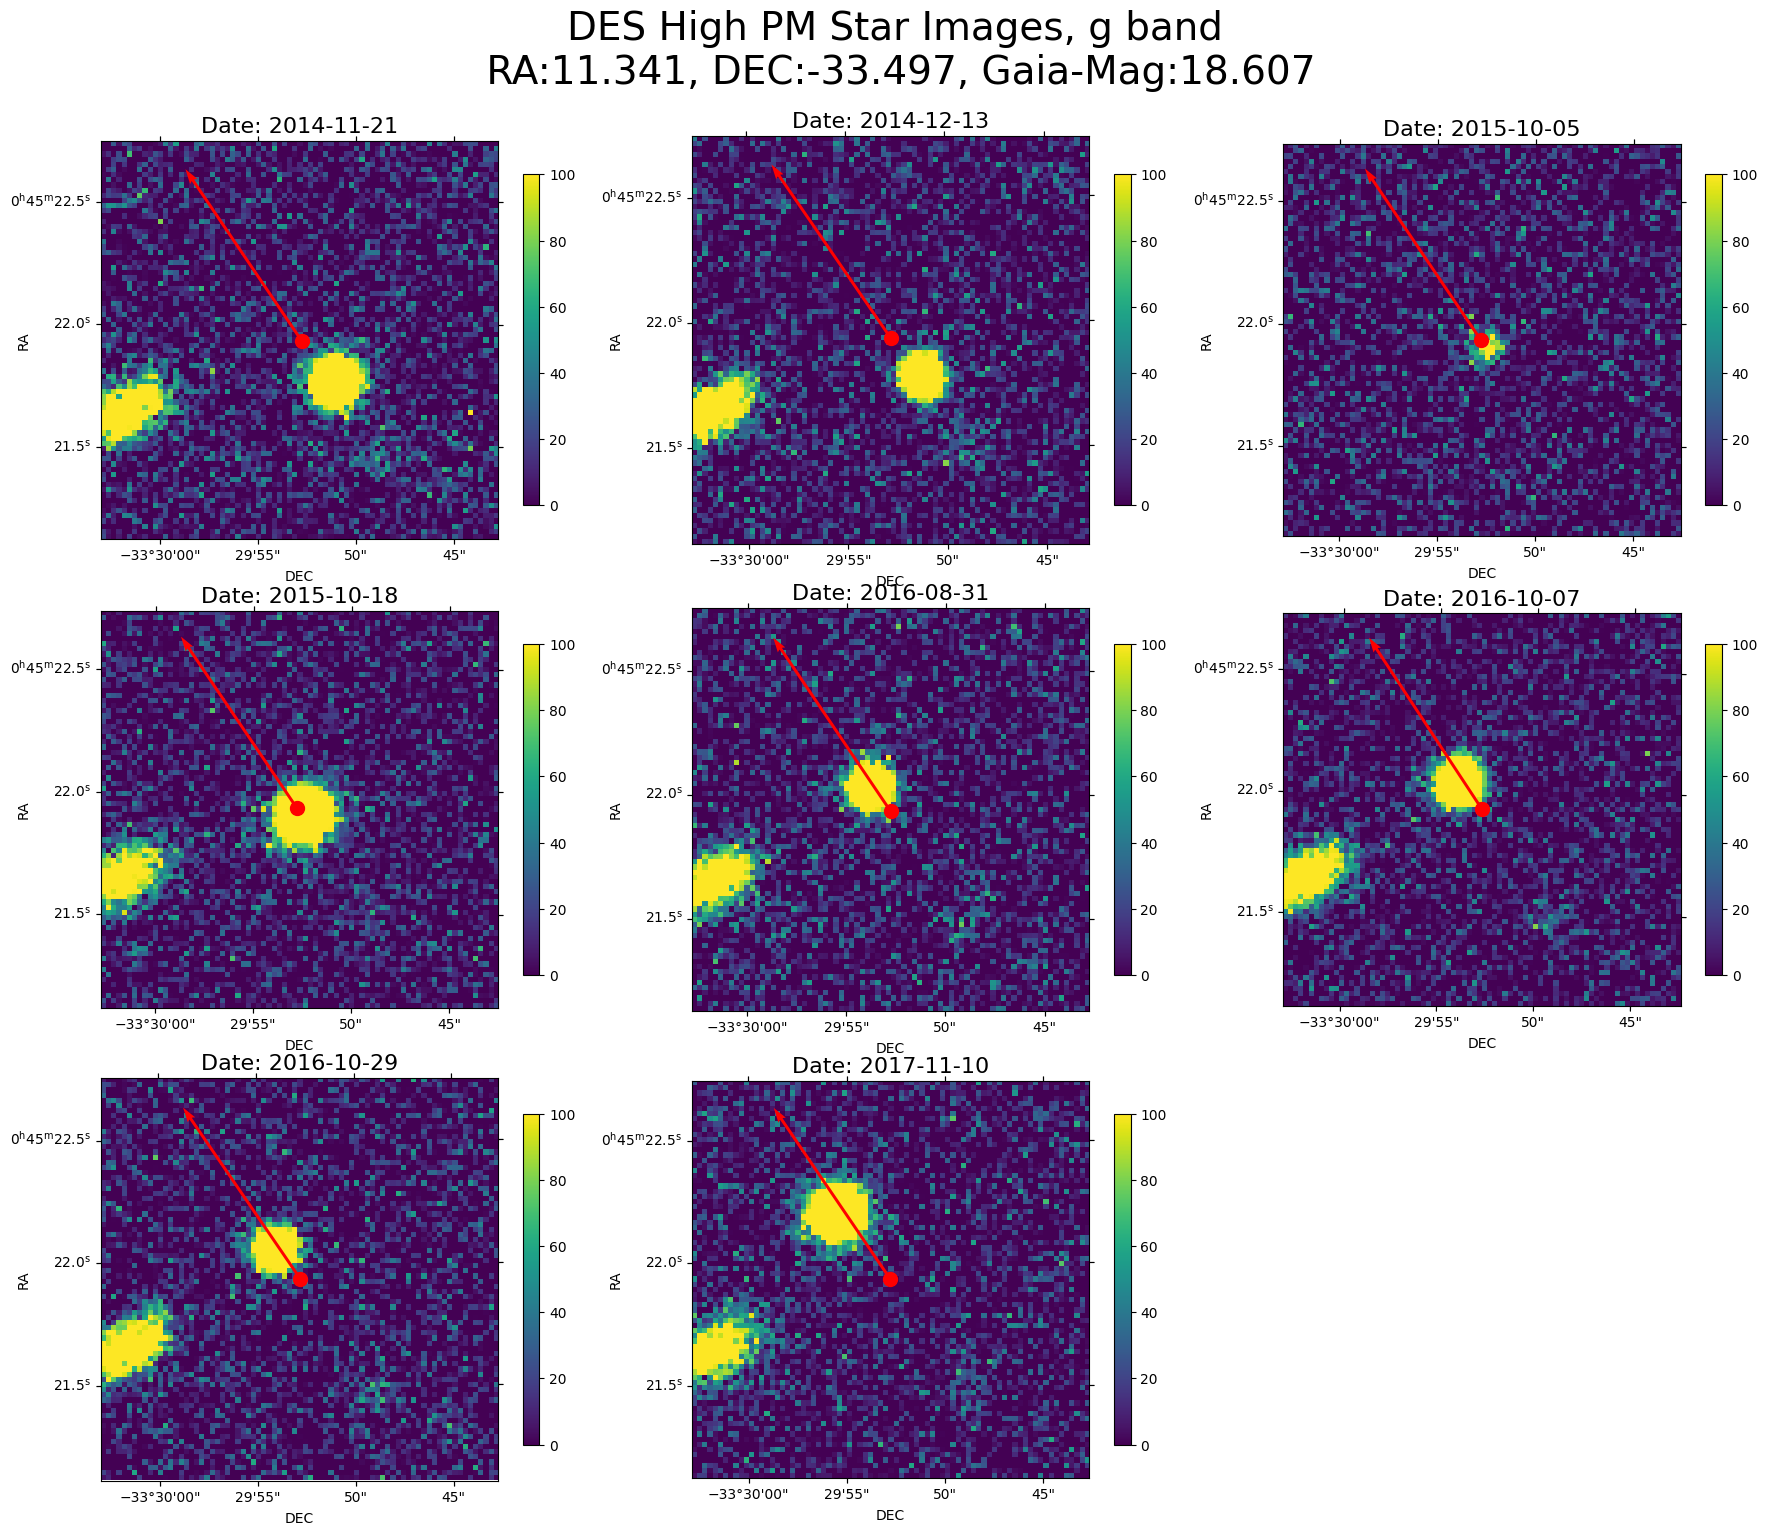

8


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

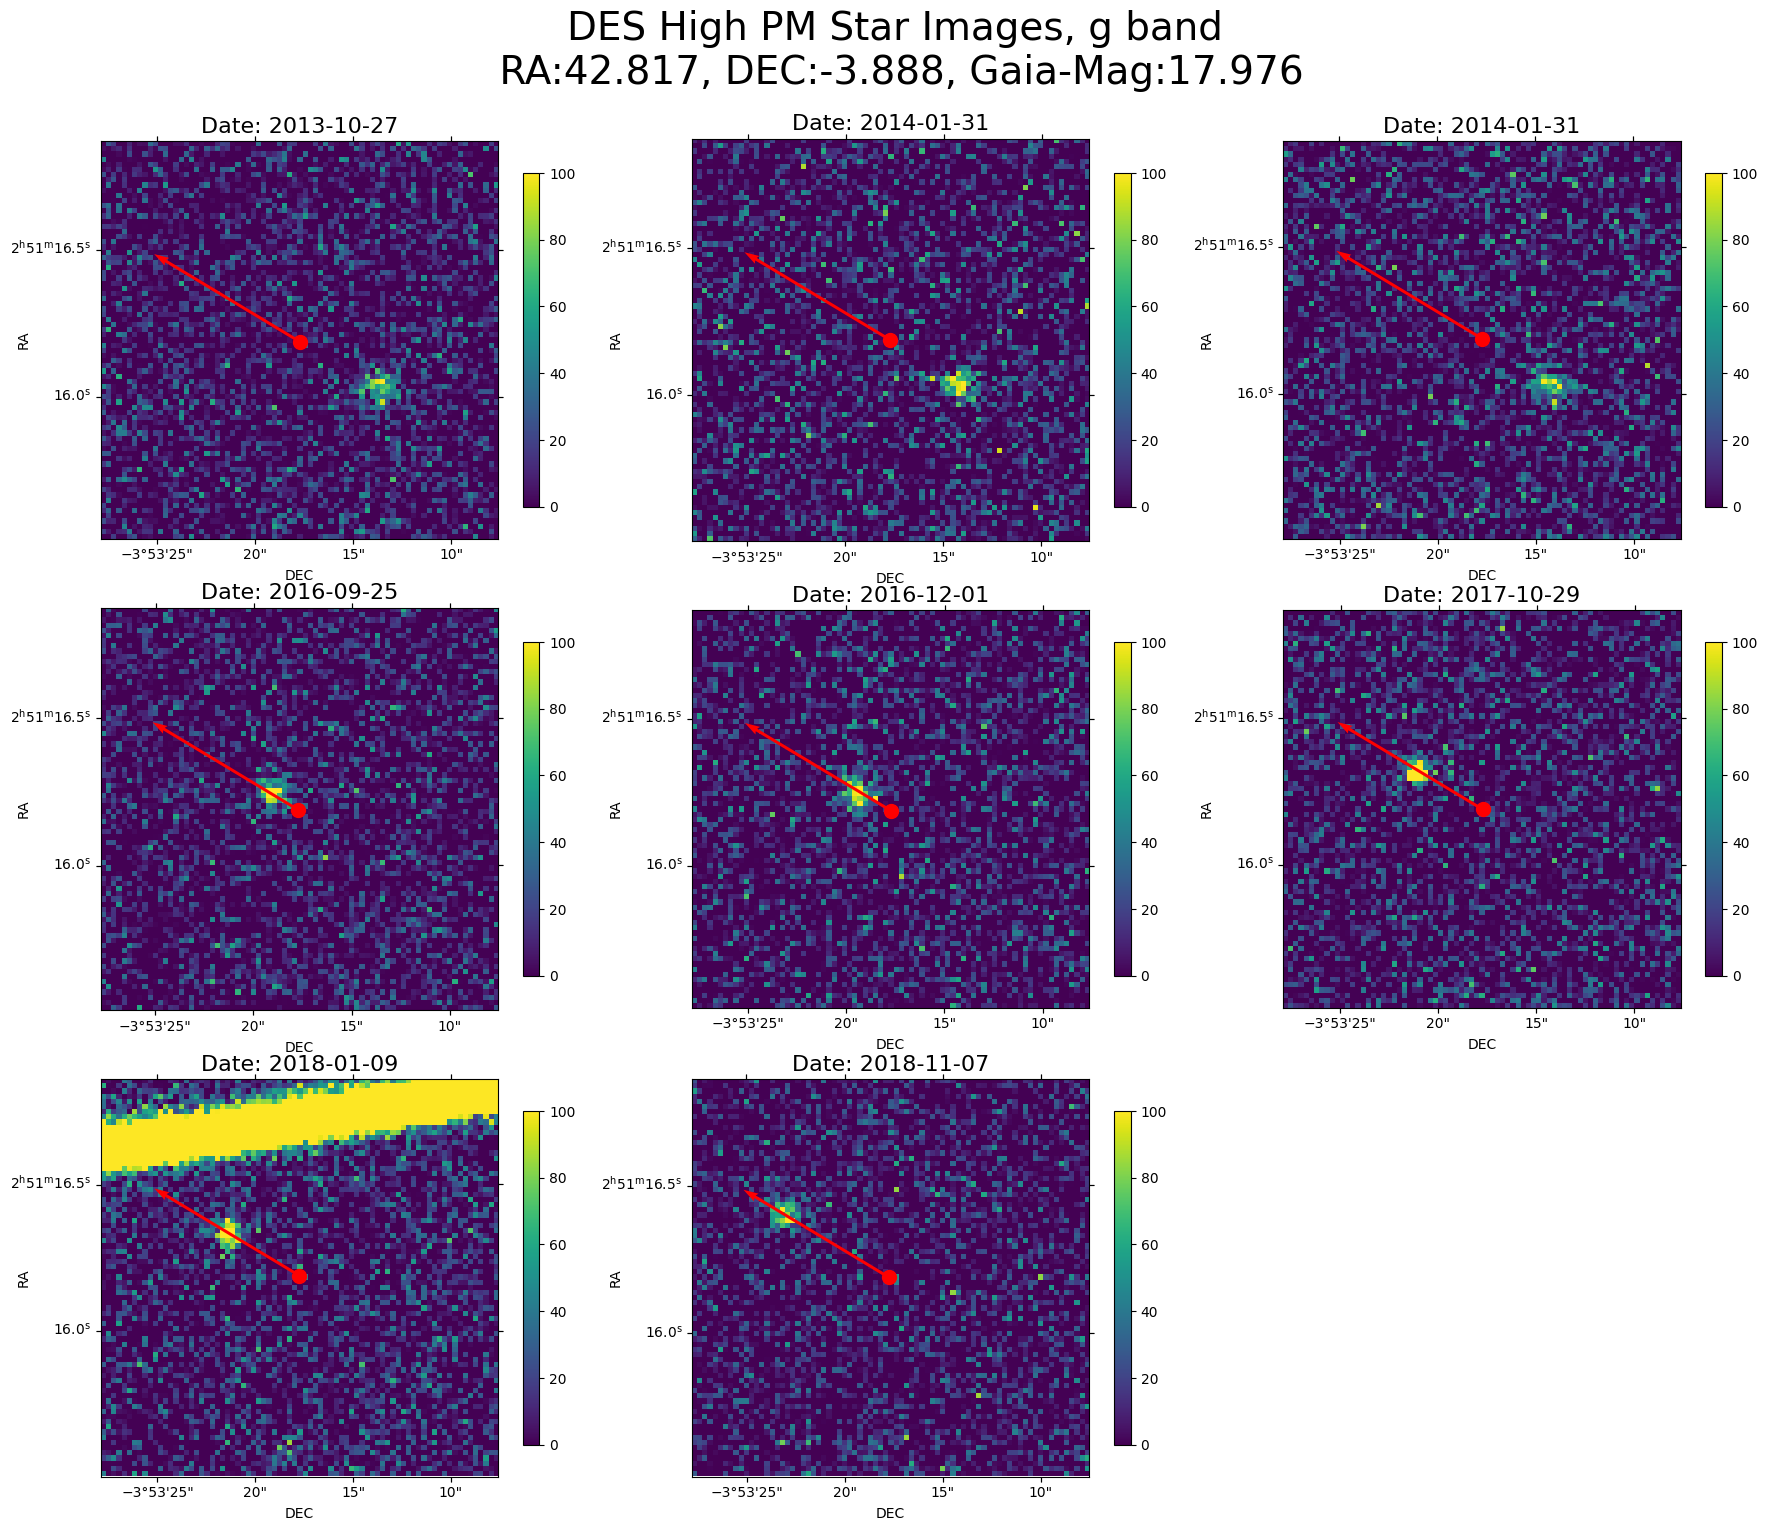

10


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

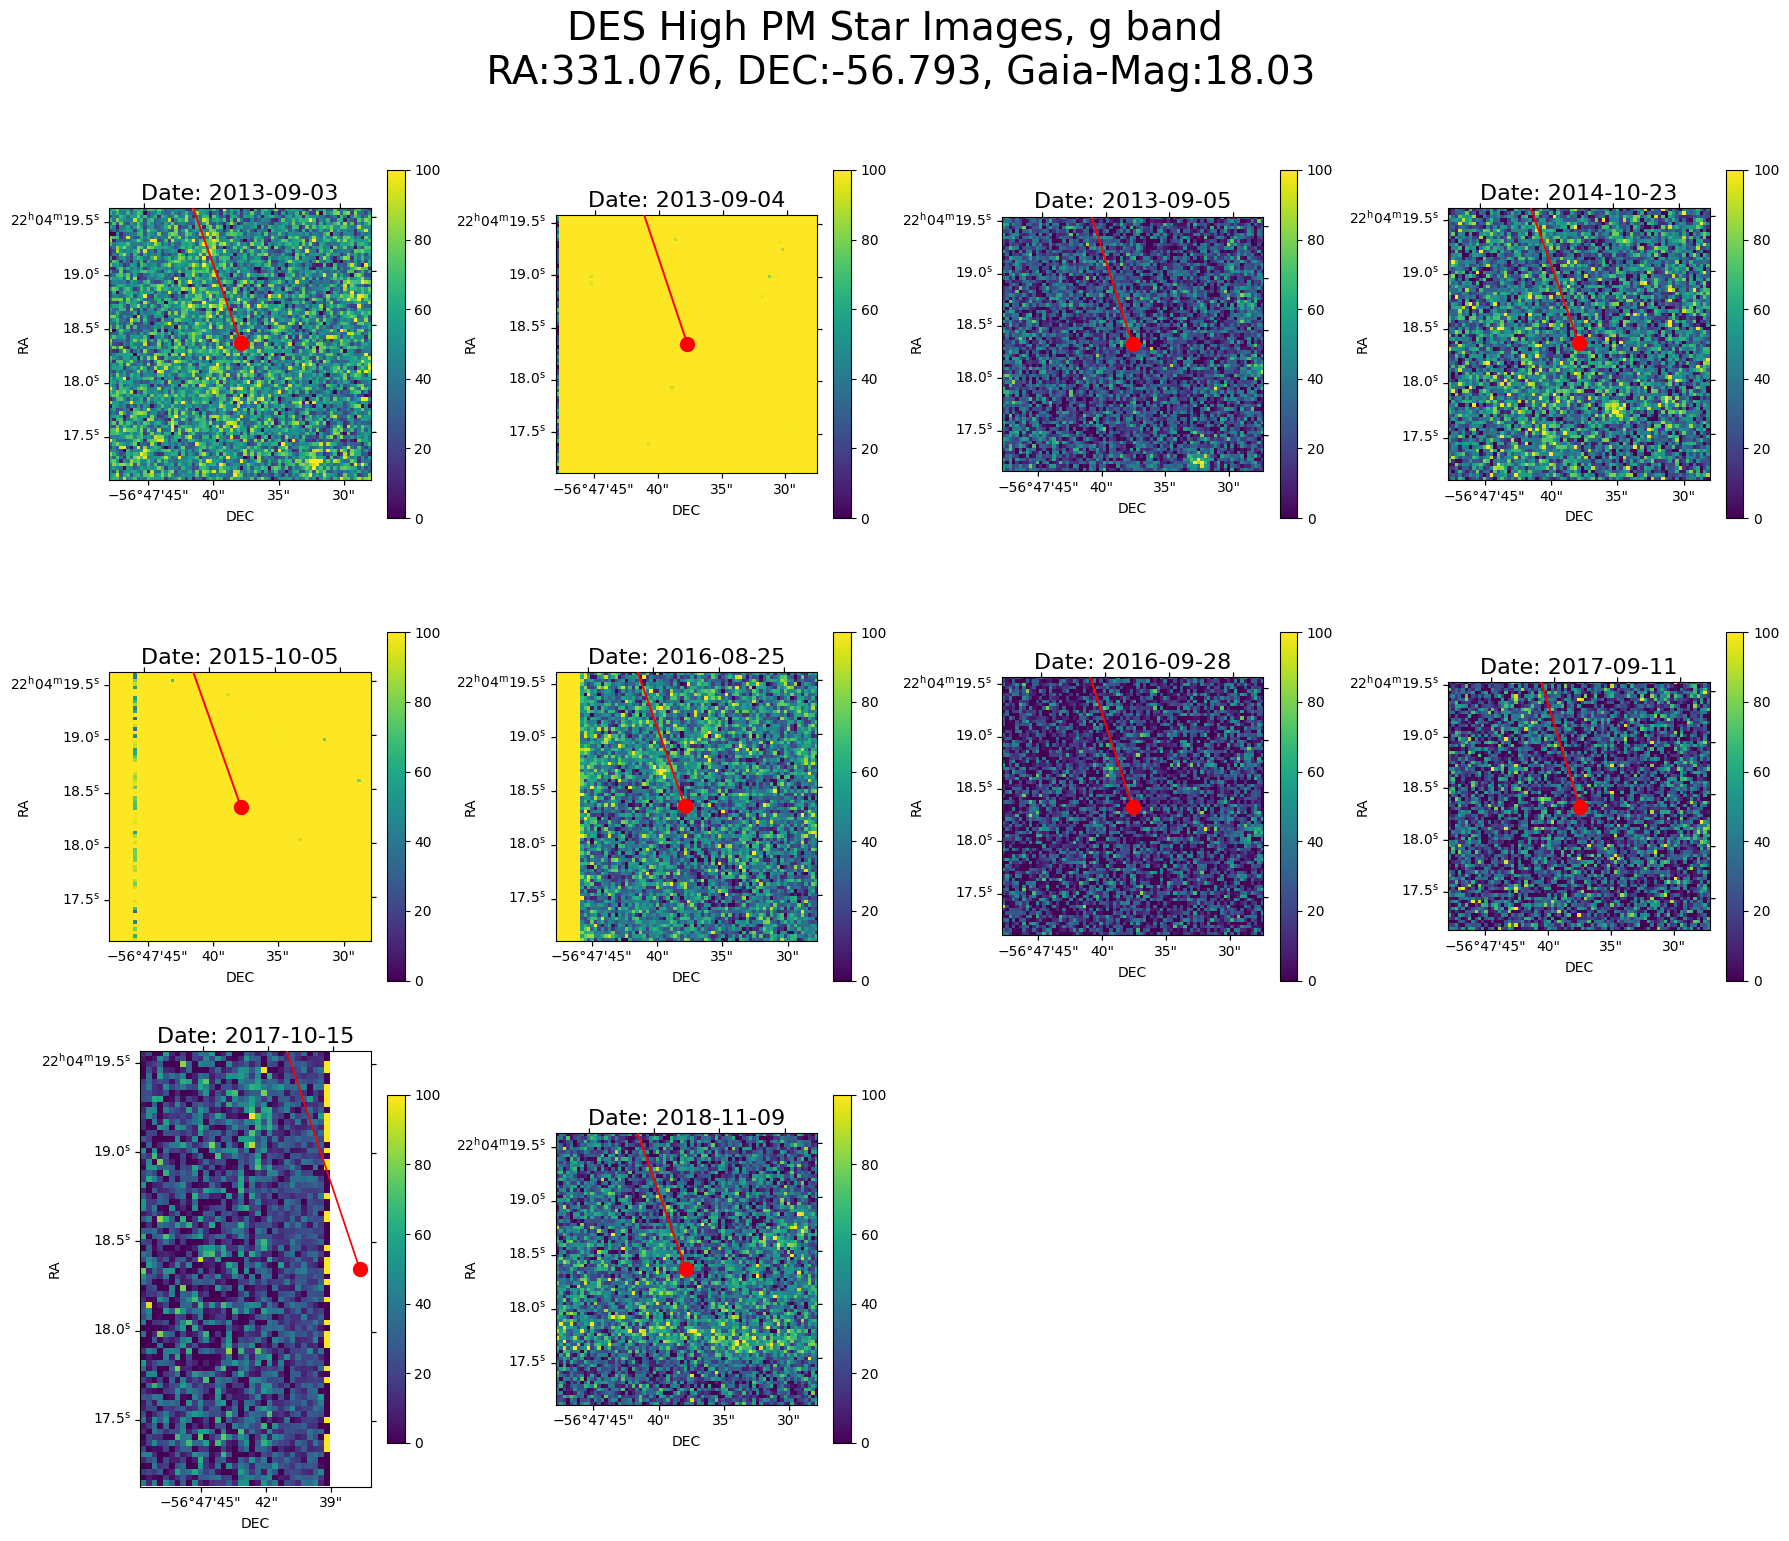

In [19]:
for index, row in pd.read_csv('../previous_work/algo_gaia_verified.csv').query('GMag_gaia > 15').iterrows():
    plot_catalog_images(DEF_ACCESS_URL, row['ra_gaia'], row['dec_gaia'], row['pmra_gaia'], row['pmdec_gaia'], row['GMag_gaia'])


In [3]:
import os
import requests
from astropy.table import Table
import urllib.parse

def download_fits_files(imgTable, ra, dec, Gmag):

    # Construct the directory path
    table_name = f"ra_{ra}_dec_{dec}_Gmag_{Gmag}"
    output_dir = os.path.join("..", "..", "..", "hpms_images_fits", "des_dr2", table_name)
    os.makedirs(output_dir, exist_ok=True)

    # Loop through the table and download each FITS file
    for i, row in enumerate(imgTable):
        full_url = row['access_url']
        parts = full_url.split('&')
        url = '&'.join(parts[:2]) if len(parts) >= 2 else full_url

        parsed_url = urllib.parse.urlparse(url)
        query_params = urllib.parse.parse_qs(parsed_url.query)
        filename = query_params.get('siaRef', [f"file_{i}.fits"])[0]
        filepath = os.path.join(output_dir, filename)

        print(f"[{i+1}/{len(imgTable)}] Downloading: {url}")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Saved to: {filepath}")
        except requests.RequestException as e:
            print(f"Failed to download {url}: {e}")

# Example usage
# download_fits_files("your_table.ecsv", ra="150.1", dec="-2.3", Gmag="17.8")


In [ ]:
def download_hpms_fits(URL, ra, dec, mag):
    catalog = sia.SIAService(URL)
    fov = 20/3600 # 20 arcseconds
    imgTable = catalog.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    download_fits_files(imgTable, ra, dec, mag)
    return None    

for index, row in pd.read_csv('../previous_work/algo_gaia_verified.csv').query('GMag_gaia > 15').iterrows():
    download_hpms_fits(DEF_ACCESS_URL, row['ra_gaia'], row['dec_gaia'], row['GMag_gaia'])


In [4]:
from pathlib import Path
import s3fs

In [10]:
%%time
CATALOG_DIR = Path("../../../catalogs")
GAIA_1000_NAME = 'gaia_dr3_pm_greater_1000'
GAIA_1000_DIR = CATALOG_DIR / GAIA_1000_NAME

gaia_pm_greater_1000 = lsdb.read_hats(GAIA_1000_DIR).query('phot_g_mean_mag > 19 or phot_g_mean_mag.isna()')
panstarrs_1_obj = lsdb.read_hats('s3://stpubdata/panstarrs/ps1/public/hats/otmo', margin_cache='s3://stpubdata/panstarrs/ps1/public/hats/otmo_10arcs')

with Client():
    gaia_x_pan = gaia_pm_greater_1000.crossmatch(panstarrs_1_obj, 
                                                 n_neighbors=100,
                                                 suffixes=['_gaia', '_panstarrs'],
                                                 radius_arcsec=10).compute()
print(len(gaia_x_pan))
gaia_x_pan

145


,source_id_gaia,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,phot_g_mean_mag_gaia,phot_bp_mean_mag_gaia,phot_rp_mean_mag_gaia,objName_panstarrs,objNameHMS_panstarrs,objAltName1_panstarrs,objAltName2_panstarrs,objAltName3_panstarrs,objPopularName_panstarrs,objID_panstarrs,uniquePspsOBid_panstarrs,ippObjID_panstarrs,surveyID_panstarrs,htmID_panstarrs,zoneID_panstarrs,tessID_panstarrs,projectionID_panstarrs,skyCellID_panstarrs,randomID_panstarrs,batchID_panstarrs,dvoRegionID_panstarrs,processingVersion_panstarrs,objInfoFlag_panstarrs,astrometryCorrectionFlag_panstarrs,qualityFlag_panstarrs,raStack_panstarrs,decStack_panstarrs,raStackErr_panstarrs,decStackErr_panstarrs,raMean_panstarrs,decMean_panstarrs,raMeanErr_panstarrs,decMeanErr_panstarrs,pmra_panstarrs,pmdec_panstarrs,pmraErr_panstarrs,pmdecErr_panstarrs,epochMean_panstarrs,posMeanChisq_panstarrs,cx_panstarrs,cy_panstarrs,cz_panstarrs,lambda_panstarrs,beta_panstarrs,l_panstarrs,b_panstarrs,nStackObjectRows_panstarrs,nStackDetections_panstarrs,nDetections_panstarrs,ng_panstarrs,nr_panstarrs,ni_panstarrs,nz_panstarrs,ny_panstarrs,gQfPerfect_panstarrs,gMeanPSFMag_panstarrs,gMeanPSFMagErr_panstarrs,gMeanPSFMagStd_panstarrs,gMeanPSFMagNpt_panstarrs,gMeanPSFMagMin_panstarrs,gMeanPSFMagMax_panstarrs,gMeanKronMag_panstarrs,gMeanKronMagErr_panstarrs,gMeanKronMagStd_panstarrs,gMeanKronMagNpt_panstarrs,gMeanApMag_panstarrs,gMeanApMagErr_panstarrs,gMeanApMagStd_panstarrs,gMeanApMagNpt_panstarrs,gFlags_panstarrs,rQfPerfect_panstarrs,rMeanPSFMag_panstarrs,rMeanPSFMagErr_panstarrs,rMeanPSFMagStd_panstarrs,rMeanPSFMagNpt_panstarrs,rMeanPSFMagMin_panstarrs,rMeanPSFMagMax_panstarrs,rMeanKronMag_panstarrs,rMeanKronMagErr_panstarrs,rMeanKronMagStd_panstarrs,rMeanKronMagNpt_panstarrs,rMeanApMag_panstarrs,rMeanApMagErr_panstarrs,rMeanApMagStd_panstarrs,rMeanApMagNpt_panstarrs,rFlags_panstarrs,iQfPerfect_panstarrs,iMeanPSFMag_panstarrs,iMeanPSFMagErr_panstarrs,iMeanPSFMagStd_panstarrs,iMeanPSFMagNpt_panstarrs,iMeanPSFMagMin_panstarrs,iMeanPSFMagMax_panstarrs,iMeanKronMag_panstarrs,iMeanKronMagErr_panstarrs,iMeanKronMagStd_panstarrs,iMeanKronMagNpt_panstarrs,iMeanApMag_panstarrs,iMeanApMagErr_panstarrs,iMeanApMagStd_panstarrs,iMeanApMagNpt_panstarrs,iFlags_panstarrs,zQfPerfect_panstarrs,zMeanPSFMag_panstarrs,zMeanPSFMagErr_panstarrs,zMeanPSFMagStd_panstarrs,zMeanPSFMagNpt_panstarrs,zMeanPSFMagMin_panstarrs,zMeanPSFMagMax_panstarrs,zMeanKronMag_panstarrs,zMeanKronMagErr_panstarrs,zMeanKronMagStd_panstarrs,zMeanKronMagNpt_panstarrs,zMeanApMag_panstarrs,zMeanApMagErr_panstarrs,zMeanApMagStd_panstarrs,zMeanApMagNpt_panstarrs,zFlags_panstarrs,yQfPerfect_panstarrs,yMeanPSFMag_panstarrs,yMeanPSFMagErr_panstarrs,yMeanPSFMagStd_panstarrs,yMeanPSFMagNpt_panstarrs,yMeanPSFMagMin_panstarrs,yMeanPSFMagMax_panstarrs,yMeanKronMag_panstarrs,yMeanKronMagErr_panstarrs,yMeanKronMagStd_panstarrs,yMeanKronMagNpt_panstarrs,yMeanApMag_panstarrs,yMeanApMagErr_panstarrs,yMeanApMagStd_panstarrs,yMeanApMagNpt_panstarrs,yFlags_panstarrs,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72355622838789655,144711230753602048,68.900732,21.250996,860.716142,-959.20791,19.120424,21.595911,17.604784,PSO J068.9006+21.2508,PSX J043536.13+211502.8,-999,-999,-999,-999,133500689005771467,3536331000052500,129974300364053,0,16713599302721,13350,1,1780,34,0.48704,3536331,30262,3,268959744,0,32,-999.0,-999.0,-999.0,-999.0,68.900577,21.25078,0.18538,0.18538,<NA>,<NA>,<NA>,<NA>,55962.313079,-999.0,0.335509,0.869519,0.362451,70.394673,-0.763928,177.013348,-17.341693,-999,0,1,0,0,0,1,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,0.005478,20.809799,0.184776,-999.0,1,20.809799,20.809799,-999.0,-999.0,-999.0,0,21.3

In [11]:
no_dupes = gaia_x_pan[~gaia_x_pan['source_id_gaia'].duplicated(keep='first')]
no_dupes

,source_id_gaia,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,phot_g_mean_mag_gaia,phot_bp_mean_mag_gaia,phot_rp_mean_mag_gaia,objName_panstarrs,objNameHMS_panstarrs,objAltName1_panstarrs,objAltName2_panstarrs,objAltName3_panstarrs,objPopularName_panstarrs,objID_panstarrs,uniquePspsOBid_panstarrs,ippObjID_panstarrs,surveyID_panstarrs,htmID_panstarrs,zoneID_panstarrs,tessID_panstarrs,projectionID_panstarrs,skyCellID_panstarrs,randomID_panstarrs,batchID_panstarrs,dvoRegionID_panstarrs,processingVersion_panstarrs,objInfoFlag_panstarrs,astrometryCorrectionFlag_panstarrs,qualityFlag_panstarrs,raStack_panstarrs,decStack_panstarrs,raStackErr_panstarrs,decStackErr_panstarrs,raMean_panstarrs,decMean_panstarrs,raMeanErr_panstarrs,decMeanErr_panstarrs,pmra_panstarrs,pmdec_panstarrs,pmraErr_panstarrs,pmdecErr_panstarrs,epochMean_panstarrs,posMeanChisq_panstarrs,cx_panstarrs,cy_panstarrs,cz_panstarrs,lambda_panstarrs,beta_panstarrs,l_panstarrs,b_panstarrs,nStackObjectRows_panstarrs,nStackDetections_panstarrs,nDetections_panstarrs,ng_panstarrs,nr_panstarrs,ni_panstarrs,nz_panstarrs,ny_panstarrs,gQfPerfect_panstarrs,gMeanPSFMag_panstarrs,gMeanPSFMagErr_panstarrs,gMeanPSFMagStd_panstarrs,gMeanPSFMagNpt_panstarrs,gMeanPSFMagMin_panstarrs,gMeanPSFMagMax_panstarrs,gMeanKronMag_panstarrs,gMeanKronMagErr_panstarrs,gMeanKronMagStd_panstarrs,gMeanKronMagNpt_panstarrs,gMeanApMag_panstarrs,gMeanApMagErr_panstarrs,gMeanApMagStd_panstarrs,gMeanApMagNpt_panstarrs,gFlags_panstarrs,rQfPerfect_panstarrs,rMeanPSFMag_panstarrs,rMeanPSFMagErr_panstarrs,rMeanPSFMagStd_panstarrs,rMeanPSFMagNpt_panstarrs,rMeanPSFMagMin_panstarrs,rMeanPSFMagMax_panstarrs,rMeanKronMag_panstarrs,rMeanKronMagErr_panstarrs,rMeanKronMagStd_panstarrs,rMeanKronMagNpt_panstarrs,rMeanApMag_panstarrs,rMeanApMagErr_panstarrs,rMeanApMagStd_panstarrs,rMeanApMagNpt_panstarrs,rFlags_panstarrs,iQfPerfect_panstarrs,iMeanPSFMag_panstarrs,iMeanPSFMagErr_panstarrs,iMeanPSFMagStd_panstarrs,iMeanPSFMagNpt_panstarrs,iMeanPSFMagMin_panstarrs,iMeanPSFMagMax_panstarrs,iMeanKronMag_panstarrs,iMeanKronMagErr_panstarrs,iMeanKronMagStd_panstarrs,iMeanKronMagNpt_panstarrs,iMeanApMag_panstarrs,iMeanApMagErr_panstarrs,iMeanApMagStd_panstarrs,iMeanApMagNpt_panstarrs,iFlags_panstarrs,zQfPerfect_panstarrs,zMeanPSFMag_panstarrs,zMeanPSFMagErr_panstarrs,zMeanPSFMagStd_panstarrs,zMeanPSFMagNpt_panstarrs,zMeanPSFMagMin_panstarrs,zMeanPSFMagMax_panstarrs,zMeanKronMag_panstarrs,zMeanKronMagErr_panstarrs,zMeanKronMagStd_panstarrs,zMeanKronMagNpt_panstarrs,zMeanApMag_panstarrs,zMeanApMagErr_panstarrs,zMeanApMagStd_panstarrs,zMeanApMagNpt_panstarrs,zFlags_panstarrs,yQfPerfect_panstarrs,yMeanPSFMag_panstarrs,yMeanPSFMagErr_panstarrs,yMeanPSFMagStd_panstarrs,yMeanPSFMagNpt_panstarrs,yMeanPSFMagMin_panstarrs,yMeanPSFMagMax_panstarrs,yMeanKronMag_panstarrs,yMeanKronMagErr_panstarrs,yMeanKronMagStd_panstarrs,yMeanKronMagNpt_panstarrs,yMeanApMag_panstarrs,yMeanApMagErr_panstarrs,yMeanApMagStd_panstarrs,yMeanApMagNpt_panstarrs,yFlags_panstarrs,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72355622838789655,144711230753602048,68.900732,21.250996,860.716142,-959.20791,19.120424,21.595911,17.604784,PSO J068.9006+21.2508,PSX J043536.13+211502.8,-999,-999,-999,-999,133500689005771467,3536331000052500,129974300364053,0,16713599302721,13350,1,1780,34,0.48704,3536331,30262,3,268959744,0,32,-999.0,-999.0,-999.0,-999.0,68.900577,21.25078,0.18538,0.18538,<NA>,<NA>,<NA>,<NA>,55962.313079,-999.0,0.335509,0.869519,0.362451,70.394673,-0.763928,177.013348,-17.341693,-999,0,1,0,0,0,1,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,0.005478,20.809799,0.184776,-999.0,1,20.809799,20.809799,-999.0,-999.0,-999.0,0,21.3

In [12]:
no_dupes.to_csv('gaia_x_pan.csv')